---
title: "Forecasting with Trees"
description: "How can Gradient Boosted Decision Trees be effective models for forecasting? A few notes."
date: "2022-12-11"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

Forecasting, the task of predicting the future, has a vast number of crucially important applications in diverse areas such as medicine, financial decision making, climate modeling, and traffic planning. Consequently, time series modelling has always been an area of intensive research leading to the development of a multitude of different forecasting methods. While traditional approaches are typically model-driven (i.e., they make rather strong assumptions, but don't require many observations to estimate model parameters), the rise of machine learning has facilitated research into data-driven approaches that require more data but are also much more flexible (see this recent [paper](https://arxiv.org/abs/2212.03523) for a deeper dive into the characteristics of forecasting methods).

In particular, recent research appears to be largely concentrated on deep learning-based forecasting, which has indeed led to many successful innovations. In recent forecasting competitions, however, it became apparent that [many teams relied heavily on Gradient Boosted Decision Trees (GBDTs)](https://arxiv.org/abs/2009.07701) to achieve top ranks – a finding that underscores the practical relevance and usefulness of tree-based models but doesn't seem to be reflected yet in the attention of researchers. A recent [review article](https://arxiv.org/abs/2012.03854), for example, that aims to provide an extensive overview of the theory and practice of forecasting doesn't shed much light on the role of tree-based models. Thus, in this blog post we'll have a look at why and how GBDTs can be effective models for forecasting. In the process, we'll also have a look at some model agnostic peculiarities of time series that need to be adressed in any forecasting problem.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sktime.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter

In [7]:
def get_ax(figsize=(11, 4), grid=False, title=None, xlabel=None, ylabel=None):
    _, ax = plt.subplots(figsize=figsize)
    if grid:
        ax.grid(axis="y", which="major", color="#e6e5e3", zorder=1)
    ax.tick_params(axis="both", labelsize=9)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1.1)
    if title is not None:
        ax.set_title(title, fontsize=12)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=10)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=10)
    return ax

## Why use GBDTs?

What motivates the use of GBDTs for forecasting, particularly as an alternative to neural networks? Let's have a cursory look at some relevant aspects (a more in-depth discussion of this topic can be found in this [paper](https://www.sciencedirect.com/science/article/pii/S0169207021001679)):

- Model implementation: Libraries like XGBoost and LightGBM are highly optimized and generally work right out of the box (i.e., it is not necessary to change their implementation). In the domain of deep learning, on the other hand, a standard architecture for forecasting has yet to emerge. While many types of models (and frameworks) have been proposed, they often require a non-trivial amount of customizations and/or experiments to work well for a given problem. 
- Hyperparameters: The default parameterization of standard GBDT libraries often provides a surprisingly competitive performance. Even if not, hyperparameter optimization is relatively straightforward with only a handful of (intuitively quite understandable) hyperparameters to tune. Tuning neural networks, meanwhile, is generally more complex, and is still often said to be more of an art than a science (i.e., it can require a lot of computation-intensive experimentation). 
- Feature engineering: While neural networks typically require only gentle feature engineering  (e.g., lag features), heavy feature engineering is considered the key to building highly competitive forecasting models with GBDTs. Fortunately, successful approaches to past problems can often be transferred to new ones (we'll dive deeper into this soon), and fast training procedures allow to try out many features. What is very important in deep learning, however, is feature scaling. Unlike GBDTs (where feature scaling doesn't matter), neural networks are typically very sensitive to the scaling of the features which can be particularly challenging when it comes to scaling lag features. A somewhat similar issue is posed by missing values which are handled natively by standard GBDT implementations but usually require imputation in deep learning.
- Diagnosability and interpretability: Arguably, diagnosing and interpreting tree-based models is relatively easy. Looking at solutions to similar problems as well as analyzing feature importances (e.g., using SHAP values) and prediction errors after running some experiments usually reveals directions for future improvements. Diagnosing and interpreting neural networks, on the other hand, is more challenging and time-consuming.
- Performance: In principle, tree-based models don't fall behind neural networks with regard to their forecasting performance. Actually, GBDTs combined with excellent feature engineering can consistently outperform neural networks. If the time series comes from a smooth process (e.g., measurements of a physical system), however, the known bias of neural networks towards smooth solutions will likely be very beneficial.

What should we make of this? In short, tree-based models come with a higher ease of use. They can benefit from known best practices and can be improved quite intuitively with feature engineering. In a sense, using GBDTs for forecasting primarily requires an intimate understanding of the data while using deep learning primarily requires an intimate understanding of the model architecture and many experiments. 

Before we dive deeper into how GBDTs can be used for forecasting, we'll visit one topic that is absolutely crucial for tackling time series with any model: model validation.

## Time Series Cross-Validation

In time series, observations that are close to each other in time are typically highly correlated. This phenomenon is known as [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) and makes intuitive sense: the sales of a given day generally provide some information about the sales of the next day, for example. It follows that we cannot use the standard cross-validation (CV) schemes (k-fold CV and its derivatives like stratified and group k-fold CV) for forecasting because they are based on the assumption that the samples are independent and identically distributed (i.i.d.) and therefore ignore chronological order. Instead we have to replicate the actual forecasting process by only validating on *future* data using a procedure called time series cross-validation (**tsCV**, also known as rolling forward CV, walk forward CV, and temporal CV). tsCV can be conducted in two different ways: using *expanding* windows or using *sliding* windows.

In [8]:
# adapted from https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
rng = np.random.RandomState(1)
cmap_cv = plt.cm.gist_earth
X = rng.randn(100, 10)

def plot_cv_indices(cv, X, ax, show_n_splits, lw=10):
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(show_n_splits))
    ax.set(
        yticks=np.arange(show_n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[show_n_splits + 0.2, -0.2],
        xlim=[0, 100],
    )
    ax.legend(
        [Patch(color=cmap_cv(0.02)), Patch(color=cmap_cv(0.8))],
        ["Training set", "Testing set"],
        loc="upper right",
        facecolor="white", 
        edgecolor="white"
    )
    return ax

### Expanding window setup

In the expanding window setup, the size of the training set increases in each successive CV iteration (i.e., the successive training sets are supersets of their predecessors) which is particularly useful when the dataset at hand is rather small. The visualization below is based on the [`ExpandingWindowSplitter`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.ExpandingWindowSplitter.html) provided in the `sktime` library.

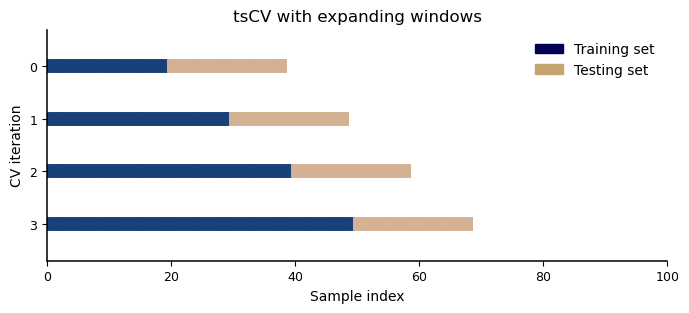

In [9]:
ax = get_ax(figsize=(8, 3), title="tsCV with expanding windows")
tscv_ex = ExpandingWindowSplitter(fh=np.arange(20), initial_window=20, step_length=10)
plot_cv_indices(tscv_ex, X, ax, show_n_splits=4);

### Sliding window setup

In the sliding window setup, the size of the training set is fixed so that the range of training rows moves forward in time with each CV iteration. Put another way, the oldest observations are dropped when new data is added to the training set, essentially keeping the model from attending to the distant past. Given enough data, this is usually the preferred setup in practice (keeping the size of the training set constant gives a more reliable estimate of a model's performance). `sktime`'s [`SlidingWindowSplitter`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html) implements this functionality.

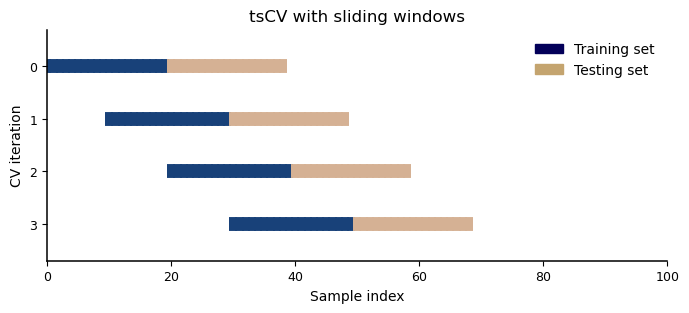

In [10]:
ax = get_ax(figsize=(8, 3), title="tsCV with sliding windows")
tscv_sl = SlidingWindowSplitter(fh=np.arange(20), window_length=20, step_length=10)
plot_cv_indices(tscv_sl, X, ax, show_n_splits=4);

### Gap to production

In practice, there is often one further issue to keep in mind: the training data usually isn't immediately available (the data has to be collected, validated, prepared, etc.) or other reasons cause a delay until the model can be put in production. If this is the case, the gap should be incorporated into the CV procedure.

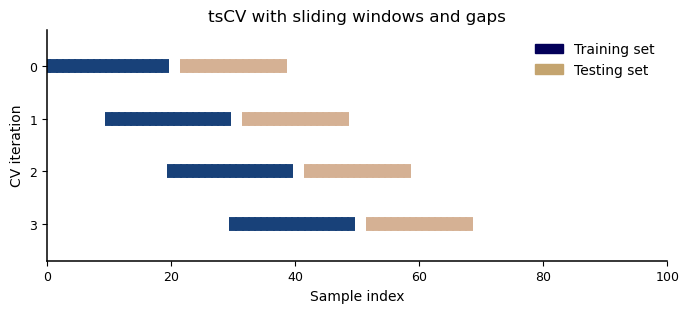

In [11]:
ax = get_ax(figsize=(8, 3), title="tsCV with sliding windows and gaps")
tscv_slg = SlidingWindowSplitter(fh=np.arange(3, 20), window_length=20, step_length=10)
plot_cv_indices(tscv_slg, X, ax, show_n_splits=4);

### Custom setup

The generic approaches outlined above may serve as a basis for developing custom tsCV procedures that consider specific quirks of the dataset (e.g., groups) or better match the characteristics of the project. If the task is to predict daily values for the next four weeks, for example, it may make sense to use only the last four weeks of the training data for validation (or some four week windows near the end of the training data).

Note that it is also possible to combine the expanding and sliding window approach (start with the expanding window setup and switch to the sliding window setup when the window has grown large enough) or compute a weighted average over all test windows to obtain the final CV score (e.g., giving more weight to a validation window that includes the last seasonal period or to the most recent window). Note that the faster training speed of GBDTs can be particularly advantageous in this context since it allows to validate against more validation windows in a timely manner.

## Evaluation Metric

With the validation scheme set up, choosing the right evaluation metric is the next important choice to make. A huge (and somewhat overwhelming) variety of metrics for evaluating forecasting models has been proposed, each with its own advantages and disadvantages. This 2022 [paper](https://arxiv.org/pdf/2203.10716.pdf) provides a thorough review and a nice flowchart for picking the right one(s). In general (and unsurprisingly), the choice of evaluation metrics should be guided by the underlying business problem. In sales forecasting, for example, overestimation might be acceptable to some degree, while underestimation should be avoided (products that are not in stock cannot be sold and being out of stock comes with significant reputational risk); the metric should reflect this. In this context, it may be worthwhile to customize the loss function used by the model (XGBoost, for example, provides a [tutorial](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html) on this) and/or transform the target to make the modeling easier.

## Modeling

In order to apply GBDTs (or other ML methods) to time series, we have to transform the data into a supervised regression problem. This essentially means nothing more than that each row must contain all the features necessary for the model to make a prediction. There are some more aspects to consider, though.

### Local vs. global models

If the dataset contains multiple time series (e.g., sales data for multiple stores), we have to decide whether to develop local models or a global model. While a local model is trained only on a single time series (e.g., on one store), a global model is trained across time series (e.g., on all stores; this is sometimes called cross-learning). If the underlying data generating process is not too dissimilar (or if we have good features that capture the differences), we will usually prefer global models since we can leverage the additional observations to build more complex and robust models. [Recent research](https://arxiv.org/pdf/2008.00444) has even shown that global models can work well for heterogenous datasets. 

### Multi-step forecasting

GBDTs generally cannot predict sequences, but many forecasting tasks are sequence-to-sequence problems. That is, we often want to predict multiple time steps into the future. If features computed from recent target values are not crucial for the model, this is not an obstacle; in this case we can treat the problem as a regular regression problem (using one model to predict each row simultaneously). If not, there are essentially two ways to implement this:
- Recursive forecasting: Recursively apply a one-step forecasting model, using the predictions of the last step for the computation of lag and window features for the current step. With this strategy the model has to be trained only once, but the accumulation of prediction errors can result in very bad model performance.
- Direct forecasting: Directly predict the entire future sequence using multiple models (i.e., train one model for each forecasting step). Requires more computation, but avoids the accumulating bias of the recursive approach.

The ideal strategy depends on many factors like the forecast horizon, the size of the dataset, the complexity of the model and the problem, as well as time and resource constraints.

### Naive baseline

When tackling forecasting problems, it is absolutely essential to compare models against naive baselines. The most common techniques:
- For non-seasonal time series, predict the last observed value. This is the simplest possible benchmark and sometimes called the persistence model or no-change model. In general, the more a time series resembles a random walk, the competitive the naive benchmark will be.
- For seasonal time series, predict the last observed seasonal value (e.g., predict the value exactly one week ago in a series with weekly periodicity). This is known as the seasonal naive method.

Of course, there may be other naive approaches that are appropriate for a particular dataset or problem (e.g., predict the median of last week), and it is generally worthwhile to check the performance of traditional (statistical) forecasting methods like ARIMA or Exponential Smoothing. Surprisingly often one finds that these baselines are quite hard to beat. Even if not, more complex models sometimes provide only a relatively small percentage improvement. (These little improvements, however, might very well have huge consequences in practice.)

### Trend adjustment

GBDTs cannot extrapolate trends. To deal with this, we can modify the target by detrending the time series. There are multiple options to do this:
- create a new target (e.g., subtract the mean target value of the last month or the last seasonal value)
- predict the residuals of a baseline model (e.g., a ridge regression model or even a more complex sequence-to-sequence neural network)
- use the predictions of a baseline model as a feature (e.g., a linear model with time steps as features or a more complex model)

### Post processing

Sometimes a simple post-processing measure (e.g., multiplying predictions by a constant just above or below $1$) can be used to correct systematic biases of a forecasting model. Of course, it is generally a bad sign when a simple  technique like that leads to significant improvements; there should be a principled way to correct a systematic error by improving the model itself. In practice though, this may be easier said than done.

## Feature Engineering

Finally, let's turn our attention to feature engineering. As with tabular data, feature engineering is crucial when tackling time series problems with tree-based methods. But due to the time dimension of the data, there are some kinds of features that are not seen in tabular problems.

### Temporal features

Many useful features can be derived from the date or time stamp associated with each observation. Some examples:

- time steps
- hour of day
- day of week
- week of year
- month
- quarter
- season
- is weekend
- is public holiday (is christmas, is easter, etc.)
- is school holiday
- is payday week
- is daylight saving time
- is event (e.g., is promotion, is world cup game, is first Saturday of the month, etc.)
- event counters (e.g., the number of days until, into, and after an event)
- number of trading days in month
- weights (e.g., put a higher weight on more recent observations or the last seasonal period)
- Fourier features

### Lag features

Lag features represent values at prior timesteps (e.g., the number of restaurant reservations on the same day last week, number of radio ads run yesterday). They can be computed for both the target and features and usually turn out to be important predictors in practice (in sales forecasting, for example, the last available value will hold a lot of information).

### Window features

Window (or rolling) features compute a summary statistic over a window of past data. This too can be done for both the target (e.g., the mean, median, standard deviation etc. of last week) and features (e.g., the minimum weekly ad spend last month). In general, one can try computing statistics for different periods (e.g., last day, the same period last season), different groups (e.g., days of the week, events), and different levels of the hierarchy (e.g., department level, state level, country level).

The optimal window sizes generally depend on the patterns in the data, but because using window features renders the data at the beginning of the time series unusable (the window features would be NaNs) it is usually better to avoid large window sizes.

### Difference features

Computing differences between different points in time (or aggregations) is another strategy that is often very useful. Intuitively, difference features help the model understand changes over time or fluctuations (e.g., subtract the weekly mean from daily observations to see how each day differs from the mean).

### Finding good features

How can we find good features? There are some strategies that can help:

- Analyze the seasonalities
- Plot the prediction errors of the model (over the entire series, by seasonality, by length of the forecast horizon, by groups in the data, etc.)
- Analyze feature importances over different periods
- Analyze solutions to similar problems

### Avoid temporal leaks

A final word of caution: when creating time-related features it is imperative to make sure that all values will be available at inference time. A rather obvious example is weather data: knowing the amount of rain or the average windspeed on a given day will most likely be of value when predicting drug store sales, but these data won't be readily available in advance. Whether or not it is possible to use predictions for these kinds of features depends on the problem (e.g., it will probably work to use weather forecasts when we only want to predict the next three days, but get prohibitively hard when we want to predict the sales of a whole month). A trickier example is target encoding (or any computation over the entire series): using the entire training data (i.e. before creating the CV split) for target encoding will create a temporal leak, causing us to overestimate the performance of the model. At inference time data leaks will end up being (highly) detrimental and might even cause the model to fail entirely.